### Install and import packages

In [1]:
# Import packages
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab10")
colors = sns.color_palette("bright")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)
np.set_printoptions(precision=5, suppress=True)

import scipy.stats as stats
import bayes_logistic

from utils import *

### Set parameters

In [2]:
# Set parameters
# data_x parameters
num_data = 2
num_data_half = num_data // 2
num_feats = 2

# num_samples 
num_samples = 10000

# weights prior distribution parameters
# weights prior distribution parameters
weights_prior_params = [
    [0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]]]

# init sigma used in numerical optimization for laplace approximation
laplace_num_iters = 1000

### Case: $N = 2$

### Generate prior and posterior samples

In [3]:
# generate data_x
# data_x = stats.uniform.rvs(0, 1, size=(num_data, num_feats), random_state=12345)
data_x = np.array([[0, 1], [1, 0]])
# print(data_x)
print(data_x.shape)

(2, 2)


In [4]:
np.random.seed(0)

# generate samples A of weights prior
samples_a_weights_prior = stats.multivariate_normal.rvs(
    weights_prior_params[0], weights_prior_params[1], 
    size=(num_samples), random_state=1)

# generate samples B of weights prior
samples_b_weights_prior = stats.multivariate_normal.rvs(
    weights_prior_params[0], weights_prior_params[1], 
    size=(num_samples), random_state=11)

# generate samples C of weights posterior using samples A of weights prior
samples_a_weights_posterior = []
samples_a_weights_posterior_pdf = []
samples_a_weights_posterior_params = []
for sidx in range(num_samples):
    # for each sample w_i in A
    sample_a_weights_prior = samples_a_weights_prior[sidx].reshape(1, num_feats)
    
    # generate sample y_i from Ber(x, w_i)
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    
    # fit laplace approximation for pair (x, y_i)
    w_map, h_map = bayes_logistic.fit_bayes_logistic(
        y = sample_a_y.squeeze(-1),
        X = data_x, 
        wprior = np.array(weights_prior_params[0]), # initialize wprior same as prior params
        H = np.linalg.inv(np.array(weights_prior_params[1])),
        weights = None,
        solver = "Newton-CG",
        bounds = None,
        maxiter = laplace_num_iters
    )
    cov_map = np.linalg.inv(h_map)
    
    # sample weights' posterior p(w|x,y_i)
    sample_a_weights_posterior = stats.multivariate_normal.rvs(w_map, cov_map)
    sample_a_weights_posterior_pdf = stats.multivariate_normal.pdf(
        sample_a_weights_posterior, w_map, cov_map).reshape(1,1)
    samples_a_weights_posterior.append(sample_a_weights_posterior)
    samples_a_weights_posterior_pdf.append(sample_a_weights_posterior_pdf)
    samples_a_weights_posterior_params.append([w_map, cov_map])

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
samples_a_weights_posterior_pdf = np.vstack(samples_a_weights_posterior_pdf)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

(10000, 2)


In [5]:
# gather groups of samples_a_weights_posterior_params by w_map 
cnt = -1
w_map_dict = OrderedDict()
samples_a_weights_posterior_clusters = []
for w_map, cov_map in samples_a_weights_posterior_params:
    if str(w_map) in w_map_dict:
        continue
    cnt += 1
    w_map_dict[str(w_map)] = w_map
    samples_a_weights_posterior_j = stats.multivariate_normal.rvs(
        w_map, cov_map, size=(num_samples), random_state=cnt).reshape(num_samples, -1)
    samples_a_weights_posterior_clusters.append(samples_a_weights_posterior_j)
w_map_list = list(w_map_dict.values())
print(len(w_map_list))

# combine laplace approximations as gaussian mixtures 
# the mixture can be either
# (1) uniform weights
# (2) post weights which is the normalized posterior pdf of samples
num_bins = 1000
x1_max = np.sqrt(weights_prior_params[1][0][0])*2.5
x2_max = np.sqrt(weights_prior_params[1][1][1])*2.5
x1_range = np.linspace(-x1_max, x1_max, num_bins)
x2_range = np.linspace(-x2_max, x2_max, num_bins)
x1_coords, x2_coords = np.meshgrid(x1_range, x2_range)
x_coords = np.concatenate((x1_coords[:,:,None], x2_coords[:,:,None]), axis=2)

uniform_mix_weights = np.ones(shape=(num_samples,1))/num_samples
post_mix_weights = samples_a_weights_posterior_pdf/np.sum(samples_a_weights_posterior_pdf)

uniform_gmm_pdf = np.zeros(shape=(num_bins,num_bins))
post_gmm_pdf = np.zeros(shape=(num_bins,num_bins))
for i in range(num_samples):
    gmm_params_i = samples_a_weights_posterior_params[i]
    gmm_pdf_i = stats.multivariate_normal.pdf(
        x_coords, gmm_params_i[0], gmm_params_i[1])
    
    uniform_gmm_pdf += uniform_mix_weights[i]*gmm_pdf_i
    post_gmm_pdf += post_mix_weights[i]*gmm_pdf_i

print(uniform_gmm_pdf.shape)

samples_a_weights_prior_pdf = stats.multivariate_normal.pdf(
        x_coords, weights_prior_params[0], weights_prior_params[1])
print(samples_a_weights_prior_pdf.shape)

4
(1000, 1000)
(1000, 1000)


### Visualize the generated prior and posterior samples

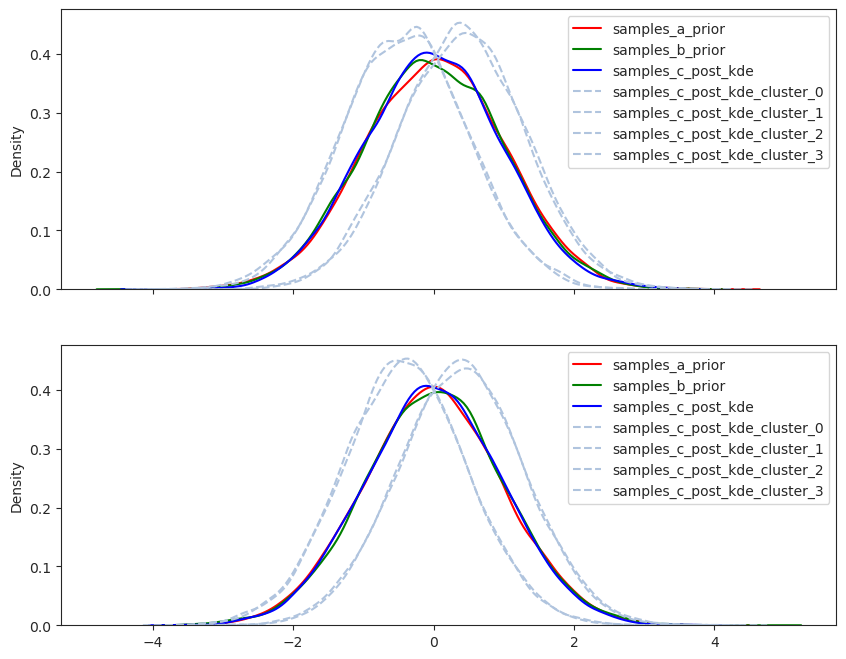

In [6]:
# visualize the marginal feature dists of prior and posterior samples
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,8))
axes = axes.flatten()

for i in range(2):
    sns.kdeplot(samples_a_weights_prior[:,i], label="samples_a_prior", 
                fill=False, color="red", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,i], label="samples_b_prior", 
                fill=False, color="green", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,i], label="samples_c_post_kde",
                fill=False, color="blue", ax=axes[i])
    for j in range(min(len(samples_a_weights_posterior_clusters), 5)):
        samples_a_weights_posterior_j = samples_a_weights_posterior_clusters[j]
        sns.kdeplot(samples_a_weights_posterior_j[:,i], fill=False, 
                    color="lightsteelblue", linestyle="--",
                    label=f"samples_c_post_kde_cluster_{j}", ax=axes[i])
        
    axes[i].legend(loc="upper right")
plt.savefig("figures/laplace_uniform_gauss_2d_n2_var01_indi_i01.png")
plt.show()

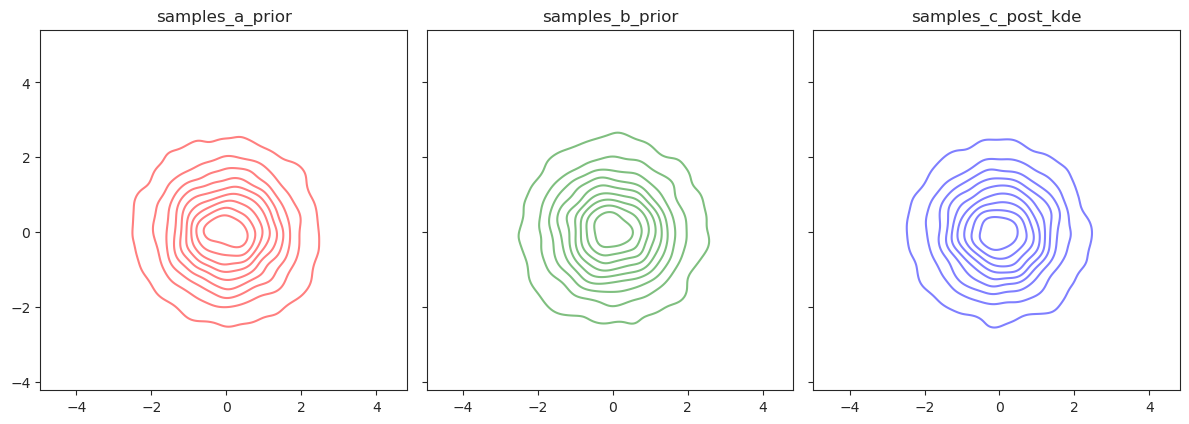

In [7]:
# visualize the joint feature dists of prior and posterior samples
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,5))
axes = axes.flatten()

alpha = 0.5
sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], 
            n_levels=10, color="red", alpha=alpha, fill=False, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], 
            n_levels=10, color="green", alpha=alpha, fill=False, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], 
            n_levels=10, color="blue", alpha=alpha, fill=False, ax=axes[2])
    
axes[0].set_aspect(aspect="equal")
axes[1].set_aspect(aspect="equal")
axes[2].set_aspect(aspect="equal")
axes[0].set_title("samples_a_prior")
axes[1].set_title("samples_b_prior")
axes[2].set_title("samples_c_post_kde")
plt.tight_layout()
plt.savefig("figures/laplace_uniform_gauss_2d_n2_var01_pair_i02.png")
plt.show()


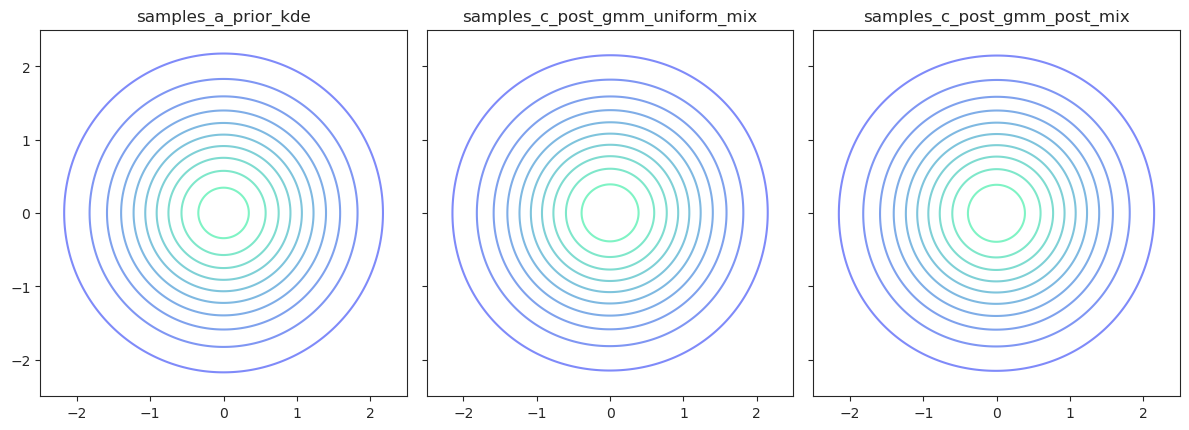

In [8]:
# visualize the joint feature dists of prior and posterior samples
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,5))
axes = axes.flatten()

alpha = 0.5
# sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], 
#             n_levels=10, cmap="winter", alpha=alpha, fill=False, ax=axes[0])

axes[0].contour(x1_coords, x2_coords, samples_a_weights_prior_pdf, 
                levels=10, cmap="winter", alpha=alpha)
axes[1].contour(x1_coords, x2_coords, uniform_gmm_pdf, 
                levels=10, cmap="winter", alpha=alpha)
axes[2].contour(x1_coords, x2_coords, post_gmm_pdf, 
                levels=10, cmap="winter", alpha=alpha)
    
axes[0].set_aspect(aspect="equal")
axes[1].set_aspect(aspect="equal")
axes[2].set_aspect(aspect="equal")
axes[0].set_title("samples_a_prior_kde")
axes[1].set_title("samples_c_post_gmm_uniform_mix")
axes[2].set_title("samples_c_post_gmm_post_mix")
plt.tight_layout()
plt.savefig("figures/laplace_uniform_gauss_2d_n2_var01_pair_i03.png")
plt.show()

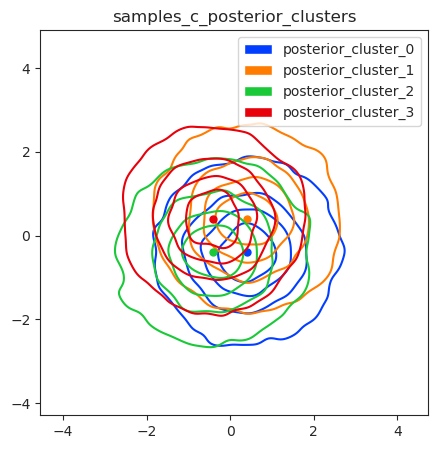

In [9]:
# visualize the joint feature distributions of clusters of approximated posteriors
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(5,5))
axes = [axes]

handles = []
for j in range(len(samples_a_weights_posterior_clusters)):
    samples_a_weights_posterior_j = samples_a_weights_posterior_clusters[j]
    w_map_j = w_map_list[j]
    sns.kdeplot(x=samples_a_weights_posterior_j[:,0], 
                y=samples_a_weights_posterior_j[:,1],
                levels=5, fill=False, alpha=1.0, color=colors[j],
                label=f"posterior_group_{j}", 
                ax=axes[0])
    handles.append(mpatches.Patch(facecolor=colors[j], label=f"posterior_cluster_{j}"))
    axes[0].plot([w_map_j[0]], [w_map_j[1]], color=colors[j], marker=".", markersize=10)
    
axes[0].set_title("samples_c_posterior_clusters")
plt.legend(handles=handles)
plt.savefig("figures/laplace_uniform_gauss_2d_n2_var01_pair_i04.png")
plt.show()

In [10]:
# # Visualize the generated prior and posterior samples, individual features
# fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10,4))
# # axes = axes.flatten()

# for i in range(1):
#     sns.kdeplot(samples_a_weights_prior[:,i], fill=False, color="red", label="samples_a_prior", ax=axes)
#     sns.kdeplot(samples_b_weights_prior[:,i], fill=False, color="green", label="samples_b_prior", ax=axes)
#     sns.kdeplot(samples_a_weights_posterior[:,i], fill=False, color="blue", label="samples_a_posterior", ax=axes)
#     axes.legend(loc="upper right")
# plt.show()

### Case: $N = 50$

### Generate prior and posterior samples

In [10]:
# generate data_x
num_data = 50
num_feats = 2
data_x = stats.uniform.rvs(0, 1, size=(num_data, num_feats), random_state=12345)
# data_x = np.array([[0, 1], [1, 0]])
# print(data_x)
print(data_x.shape)

(50, 2)


In [11]:
np.random.seed(0)

# generate samples A of weights prior
samples_a_weights_prior = stats.multivariate_normal.rvs(
    weights_prior_params[0], weights_prior_params[1], 
    size=(num_samples), random_state=1)

# generate samples B of weights prior
samples_b_weights_prior = stats.multivariate_normal.rvs(
    weights_prior_params[0], weights_prior_params[1], 
    size=(num_samples), random_state=11)

# generate samples C of weights posterior using samples A of weights prior
samples_a_weights_posterior = []
samples_a_weights_posterior_pdf = []
samples_a_weights_posterior_params = []
for sidx in range(num_samples):
    # for each sample w_i in A
    sample_a_weights_prior = samples_a_weights_prior[sidx].reshape(1, num_feats)
    
    # generate sample y_i from Ber(x, w_i)
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    
    # fit laplace approximation for pair (x, y_i)
    w_map, h_map = bayes_logistic.fit_bayes_logistic(
        y = sample_a_y.squeeze(-1),
        X = data_x, 
        wprior = np.array(weights_prior_params[0]), # initialize wprior same as prior params
        H = np.linalg.inv(np.array(weights_prior_params[1])),
        weights = None,
        solver = "Newton-CG",
        bounds = None,
        maxiter = laplace_num_iters
    )
    cov_map = np.linalg.inv(h_map)
    
    # sample weights' posterior p(w|x,y_i)
    sample_a_weights_posterior = stats.multivariate_normal.rvs(w_map, cov_map)
    sample_a_weights_posterior_pdf = stats.multivariate_normal.pdf(
        sample_a_weights_posterior, w_map, cov_map).reshape(1,1)
    samples_a_weights_posterior.append(sample_a_weights_posterior)
    samples_a_weights_posterior_pdf.append(sample_a_weights_posterior_pdf)
    samples_a_weights_posterior_params.append([w_map, cov_map])

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
samples_a_weights_posterior_pdf = np.vstack(samples_a_weights_posterior_pdf)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

(10000, 2)


In [12]:
# gather groups of samples_a_weights_posterior_params by w_map 
cnt = -1
w_map_dict = OrderedDict()
samples_a_weights_posterior_clusters = []
for w_map, cov_map in samples_a_weights_posterior_params:
    if str(w_map) in w_map_dict:
        continue
    cnt += 1
    w_map_dict[str(w_map)] = w_map
    samples_a_weights_posterior_j = stats.multivariate_normal.rvs(
        w_map, cov_map, size=(num_samples), random_state=cnt).reshape(num_samples, -1)
    samples_a_weights_posterior_clusters.append(samples_a_weights_posterior_j)
w_map_list = list(w_map_dict.values())
print(len(w_map_list))

# combine laplace approximations as gaussian mixtures 
# the mixture can be either
# (1) uniform weights
# (2) post weights which is the normalized posterior pdf of samples
num_bins = 1000
x1_max = np.sqrt(weights_prior_params[1][0][0])*2.5
x2_max = np.sqrt(weights_prior_params[1][1][1])*2.5
x1_range = np.linspace(-x1_max, x1_max, num_bins)
x2_range = np.linspace(-x2_max, x2_max, num_bins)
x1_coords, x2_coords = np.meshgrid(x1_range, x2_range)
x_coords = np.concatenate((x1_coords[:,:,None], x2_coords[:,:,None]), axis=2)

uniform_mix_weights = np.ones(shape=(num_samples,1))/num_samples
post_mix_weights = samples_a_weights_posterior_pdf/np.sum(samples_a_weights_posterior_pdf)

uniform_gmm_pdf = np.zeros(shape=(num_bins,num_bins))
post_gmm_pdf = np.zeros(shape=(num_bins,num_bins))
for i in range(num_samples):
    gmm_params_i = samples_a_weights_posterior_params[i]
    gmm_pdf_i = stats.multivariate_normal.pdf(
        x_coords, gmm_params_i[0], gmm_params_i[1])
    
    uniform_gmm_pdf += uniform_mix_weights[i]*gmm_pdf_i
    post_gmm_pdf += post_mix_weights[i]*gmm_pdf_i

print(uniform_gmm_pdf.shape)

samples_a_weights_prior_pdf = stats.multivariate_normal.pdf(
        x_coords, weights_prior_params[0], weights_prior_params[1])
print(samples_a_weights_prior_pdf.shape)

10000
(1000, 1000)
(1000, 1000)


### Visualize the generated prior and posterior samples

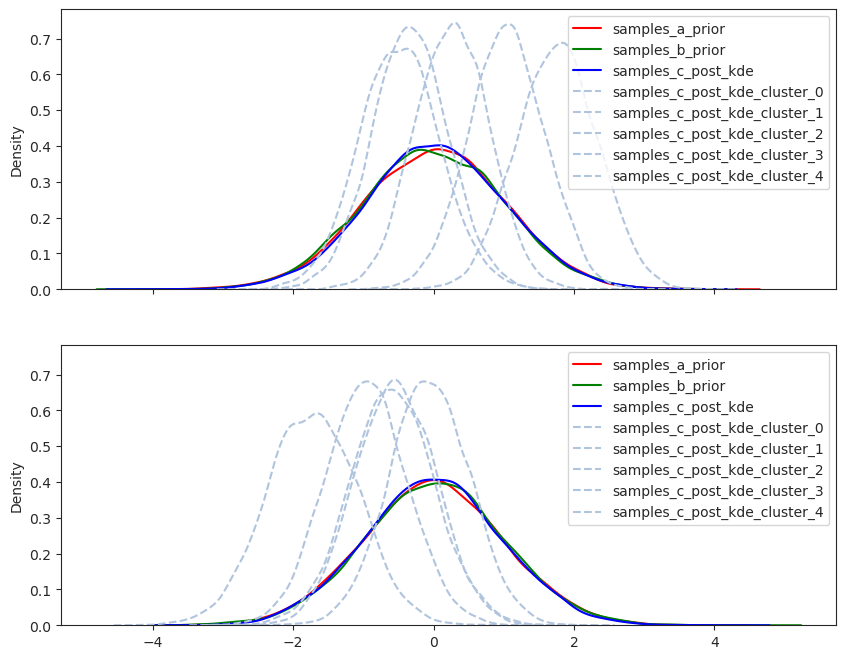

In [13]:
# visualize the marginal feature dists of prior and posterior samples
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,8))
axes = axes.flatten()

for i in range(2):
    sns.kdeplot(samples_a_weights_prior[:,i], label="samples_a_prior", 
                fill=False, color="red", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,i], label="samples_b_prior", 
                fill=False, color="green", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,i], label="samples_c_post_kde",
                fill=False, color="blue", ax=axes[i])
    for j in range(min(len(samples_a_weights_posterior_clusters), 5)):
        samples_a_weights_posterior_j = samples_a_weights_posterior_clusters[j]
        sns.kdeplot(samples_a_weights_posterior_j[:,i], fill=False, 
                    color="lightsteelblue", linestyle="--",
                    label=f"samples_c_post_kde_cluster_{j}", ax=axes[i])
        
    axes[i].legend(loc="upper right")
plt.savefig("figures/laplace_uniform_gauss_2d_n50_var01_indi_i01.png")
plt.show()

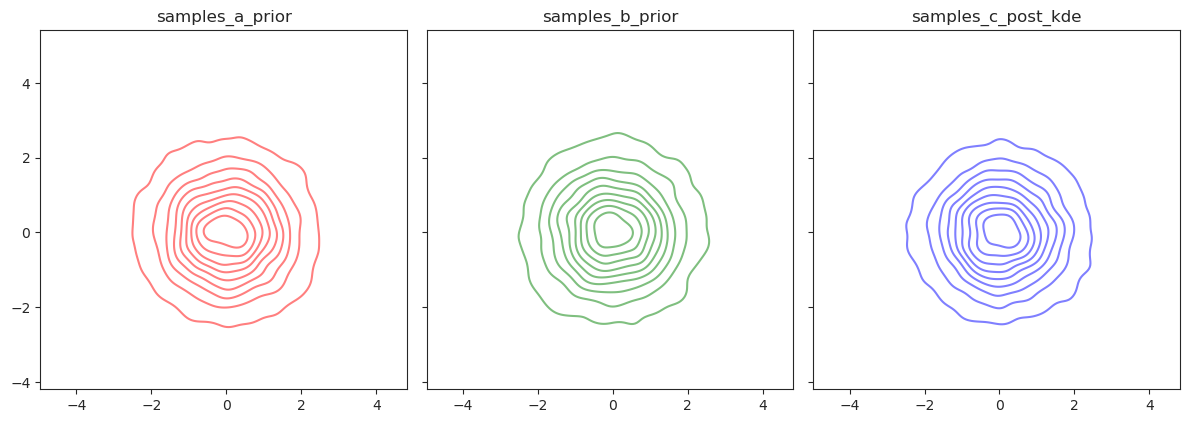

In [14]:
# visualize the joint feature dists of prior and posterior samples
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,5))
axes = axes.flatten()

alpha = 0.5
sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], 
            n_levels=10, color="red", alpha=alpha, fill=False, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], 
            n_levels=10, color="green", alpha=alpha, fill=False, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], 
            n_levels=10, color="blue", alpha=alpha, fill=False, ax=axes[2])
    
axes[0].set_aspect(aspect="equal")
axes[1].set_aspect(aspect="equal")
axes[2].set_aspect(aspect="equal")
axes[0].set_title("samples_a_prior")
axes[1].set_title("samples_b_prior")
axes[2].set_title("samples_c_post_kde")
plt.tight_layout()
plt.savefig("figures/laplace_uniform_gauss_2d_n50_var01_pair_i02.png")
plt.show()


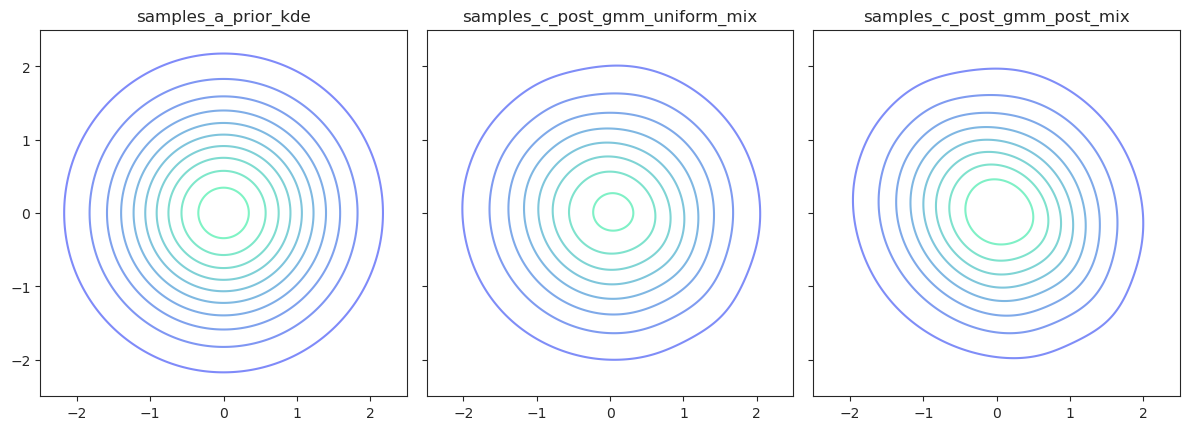

In [15]:
# visualize the joint feature dists of prior and posterior samples
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,5))
axes = axes.flatten()

alpha = 0.5
# sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], 
#             n_levels=10, cmap="winter", alpha=alpha, fill=False, ax=axes[0])

axes[0].contour(x1_coords, x2_coords, samples_a_weights_prior_pdf, 
                levels=10, cmap="winter", alpha=alpha)
axes[1].contour(x1_coords, x2_coords, uniform_gmm_pdf, 
                levels=10, cmap="winter", alpha=alpha)
axes[2].contour(x1_coords, x2_coords, post_gmm_pdf, 
                levels=10, cmap="winter", alpha=alpha)
    
axes[0].set_aspect(aspect="equal")
axes[1].set_aspect(aspect="equal")
axes[2].set_aspect(aspect="equal")
axes[0].set_title("samples_a_prior_kde")
axes[1].set_title("samples_c_post_gmm_uniform_mix")
axes[2].set_title("samples_c_post_gmm_post_mix")
plt.tight_layout()
plt.savefig("figures/laplace_uniform_gauss_2d_n50_var01_pair_i03.png")
plt.show()

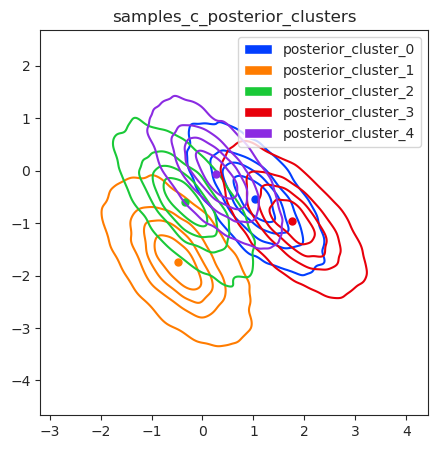

In [18]:
# visualize the joint feature distributions of clusters of approximated posteriors
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(5,5))
axes = [axes]

handles = []
for j in range(min(len(samples_a_weights_posterior_clusters), 5)):
    samples_a_weights_posterior_j = samples_a_weights_posterior_clusters[j]
    w_map_j = w_map_list[j]
    sns.kdeplot(x=samples_a_weights_posterior_j[:,0], 
                y=samples_a_weights_posterior_j[:,1],
                levels=5, fill=False, alpha=1.0, color=colors[j],
                label=f"posterior_group_{j}", 
                ax=axes[0])
    handles.append(mpatches.Patch(facecolor=colors[j], label=f"posterior_cluster_{j}"))
    axes[0].plot([w_map_j[0]], [w_map_j[1]], color=colors[j], marker=".", markersize=10)
    
axes[0].set_title("samples_c_posterior_clusters")
plt.legend(handles=handles)
plt.savefig("figures/laplace_uniform_gauss_2d_n50_var01_pair_i04.png")
plt.show()

### Case: $N = 10$

### Generate prior and posterior samples

In [14]:
# generate data_x
num_data = 10
num_feats = 2
data_x = stats.uniform.rvs(0, 1, size=(num_data, num_feats), random_state=12345)
# data_x = np.array([[0, 1], [1, 0]])
# print(data_x)
print(data_x.shape)

(10, 2)


In [15]:
np.random.seed(0)

# generate samples A of weights prior
samples_a_weights_prior = stats.multivariate_normal.rvs(
    weights_prior_params[0], weights_prior_params[1], 
    size=(num_samples), random_state=1)

# generate samples B of weights prior
samples_b_weights_prior = stats.multivariate_normal.rvs(
    weights_prior_params[0], weights_prior_params[1], 
    size=(num_samples), random_state=11)

# generate samples C of weights posterior using samples A of weights prior
samples_a_weights_posterior = []
samples_a_weights_posterior_pdf = []
samples_a_weights_posterior_params = []
for sidx in range(num_samples):
    # for each sample w_i in A
    sample_a_weights_prior = samples_a_weights_prior[sidx].reshape(1, num_feats)
    
    # generate sample y_i from Ber(x, w_i)
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    
    # fit laplace approximation for pair (x, y_i)
    w_map, h_map = bayes_logistic.fit_bayes_logistic(
        y = sample_a_y.squeeze(-1),
        X = data_x, 
        wprior = np.array(weights_prior_params[0]), # initialize wprior same as prior params
        H = np.linalg.inv(np.array(weights_prior_params[1])),
        weights = None,
        solver = "Newton-CG",
        bounds = None,
        maxiter = laplace_num_iters
    )
    cov_map = np.linalg.inv(h_map)
    
    # sample weights' posterior p(w|x,y_i)
    sample_a_weights_posterior = stats.multivariate_normal.rvs(w_map, cov_map)
    sample_a_weights_posterior_pdf = stats.multivariate_normal.pdf(
        sample_a_weights_posterior, w_map, cov_map).reshape(1,1)
    samples_a_weights_posterior.append(sample_a_weights_posterior)
    samples_a_weights_posterior_pdf.append(sample_a_weights_posterior_pdf)
    samples_a_weights_posterior_params.append([w_map, cov_map])

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
samples_a_weights_posterior_pdf = np.vstack(samples_a_weights_posterior_pdf)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

(10000, 2)


In [16]:
# gather groups of samples_a_weights_posterior_params by w_map 
cnt = -1
w_map_dict = OrderedDict()
samples_a_weights_posterior_clusters = []
for w_map, cov_map in samples_a_weights_posterior_params:
    if str(w_map) in w_map_dict:
        continue
    cnt += 1
    w_map_dict[str(w_map)] = w_map
    samples_a_weights_posterior_j = stats.multivariate_normal.rvs(
        w_map, cov_map, size=(num_samples), random_state=cnt).reshape(num_samples, -1)
    samples_a_weights_posterior_clusters.append(samples_a_weights_posterior_j)
w_map_list = list(w_map_dict.values())
print(len(w_map_list))

# combine laplace approximations as gaussian mixtures 
# the mixture can be either
# (1) uniform weights
# (2) post weights which is the normalized posterior pdf of samples
num_bins = 1000
x1_max = np.sqrt(weights_prior_params[1][0][0])*2.5
x2_max = np.sqrt(weights_prior_params[1][1][1])*2.5
x1_range = np.linspace(-x1_max, x1_max, num_bins)
x2_range = np.linspace(-x2_max, x2_max, num_bins)
x1_coords, x2_coords = np.meshgrid(x1_range, x2_range)
x_coords = np.concatenate((x1_coords[:,:,None], x2_coords[:,:,None]), axis=2)

uniform_mix_weights = np.ones(shape=(num_samples,1))/num_samples
post_mix_weights = samples_a_weights_posterior_pdf/np.sum(samples_a_weights_posterior_pdf)

uniform_gmm_pdf = np.zeros(shape=(num_bins,num_bins))
post_gmm_pdf = np.zeros(shape=(num_bins,num_bins))
for i in range(num_samples):
    gmm_params_i = samples_a_weights_posterior_params[i]
    gmm_pdf_i = stats.multivariate_normal.pdf(
        x_coords, gmm_params_i[0], gmm_params_i[1])
    
    uniform_gmm_pdf += uniform_mix_weights[i]*gmm_pdf_i
    post_gmm_pdf += post_mix_weights[i]*gmm_pdf_i

print(uniform_gmm_pdf.shape)

samples_a_weights_prior_pdf = stats.multivariate_normal.pdf(
        x_coords, weights_prior_params[0], weights_prior_params[1])
print(samples_a_weights_prior_pdf.shape)

722
(1000, 1000)
(1000, 1000)


### Visualize the generated prior and posterior samples

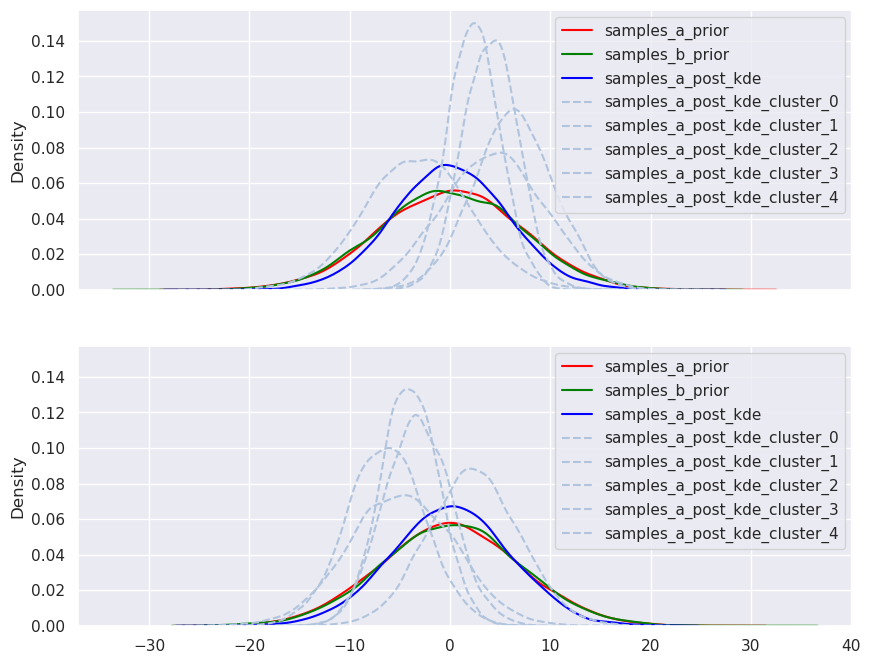

In [17]:
# visualize the marginal feature dists of prior and posterior samples
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10,8))
axes = axes.flatten()

for i in range(2):
    sns.kdeplot(samples_a_weights_prior[:,i], label="samples_a_prior", 
                fill=False, color="red", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,i], label="samples_b_prior", 
                fill=False, color="green", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,i], label="samples_a_post_kde",
                fill=False, color="blue", ax=axes[i])
    for j in range(min(len(samples_a_weights_posterior_clusters), 5)):
        samples_a_weights_posterior_j = samples_a_weights_posterior_clusters[j]
        sns.kdeplot(samples_a_weights_posterior_j[:,i], fill=False, 
                    color="lightsteelblue", linestyle="--",
                    label=f"samples_a_post_kde_cluster_{j}", ax=axes[i])
        
    axes[i].legend(loc="upper right")
plt.show()

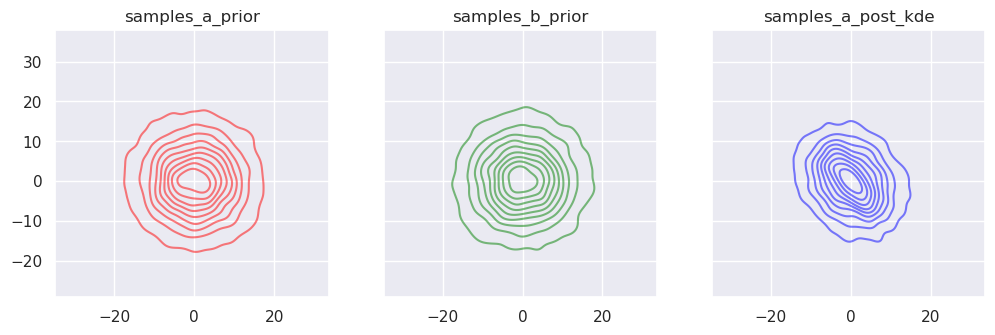

In [18]:
# visualize the joint feature dists of prior and posterior samples
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,8))
axes = axes.flatten()

alpha = 0.5
sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], 
            n_levels=10, color="red", alpha=alpha, fill=False, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], 
            n_levels=10, color="green", alpha=alpha, fill=False, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], 
            n_levels=10, color="blue", alpha=alpha, fill=False, ax=axes[2])
    
axes[0].set_aspect(aspect="equal")
axes[1].set_aspect(aspect="equal")
axes[2].set_aspect(aspect="equal")
axes[0].set_title("samples_a_prior")
axes[1].set_title("samples_b_prior")
axes[2].set_title("samples_a_post_kde")
plt.show()


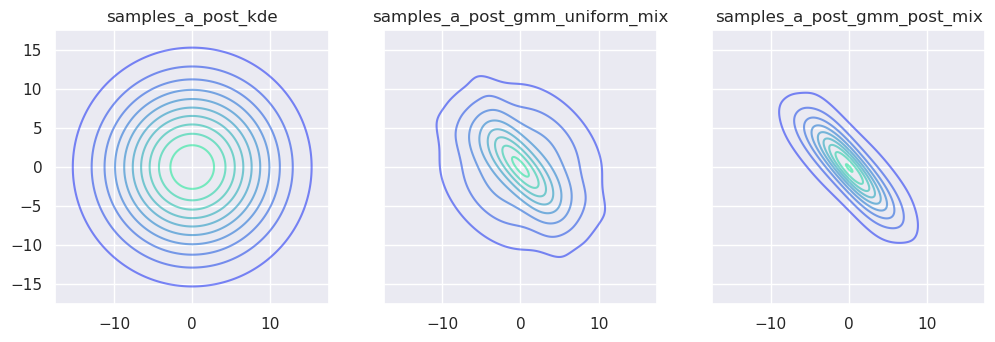

In [19]:
# visualize the joint feature dists of prior and posterior samples
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,8))
axes = axes.flatten()

alpha = 0.5
# sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], 
#             n_levels=10, cmap="winter", alpha=alpha, fill=False, ax=axes[0])

axes[0].contour(x1_coords, x2_coords, samples_a_weights_prior_pdf, 
                levels=10, cmap="winter", alpha=alpha)
axes[1].contour(x1_coords, x2_coords, uniform_gmm_pdf, 
                levels=10, cmap="winter", alpha=alpha)
axes[2].contour(x1_coords, x2_coords, post_gmm_pdf, 
                levels=10, cmap="winter", alpha=alpha)
    
axes[0].set_aspect(aspect="equal")
axes[1].set_aspect(aspect="equal")
axes[2].set_aspect(aspect="equal")
axes[0].set_title("samples_a_post_kde")
axes[1].set_title("samples_a_post_gmm_uniform_mix")
axes[2].set_title("samples_a_post_gmm_post_mix")
plt.show()

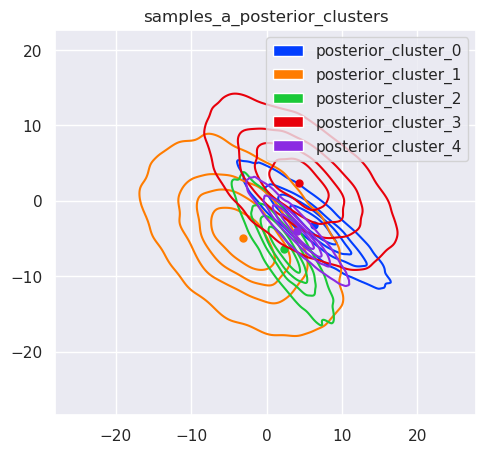

In [20]:
# visualize the joint feature distributions of clusters of approximated posteriors
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(10,5))
axes = [axes]

handles = []
for j in range(min(len(samples_a_weights_posterior_clusters),5)):
    samples_a_weights_posterior_j = samples_a_weights_posterior_clusters[j]
    w_map_j = w_map_list[j]
    sns.kdeplot(x=samples_a_weights_posterior_j[:,0], 
                y=samples_a_weights_posterior_j[:,1],
                levels=5, fill=False, alpha=1.0, color=colors[j],
                label=f"posterior_group_{j}", 
                ax=axes[0])
    handles.append(mpatches.Patch(facecolor=colors[j], label=f"posterior_cluster_{j}"))
    axes[0].plot([w_map_j[0]], [w_map_j[1]], color=colors[j], marker=".", markersize=10)
    
axes[0].set_aspect(aspect="equal")
axes[0].set_title("samples_a_posterior_clusters")
plt.legend(handles=handles)
plt.show()